# Workshop on CIFAR10

Today you will be working on CIFAR10 on your own.

Good luck!

In [1]:
#load everything
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import sys, time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#change this five times to get 5 cross validation
SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


## 1. ETL

In [3]:
#use datasets.CIFAR to get train and test
#then split train to train and val in the percentage of 80:20
transform = transforms.ToTensor()

In [4]:
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

train_data = datasets.CIFAR10(root="../data", train=True, 
                              download=True, transform=transform)
test_set   = datasets.CIFAR10(root="../data", train=False, 
                              download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(train_data), len(test_set)

(50000, 10000)

In [6]:
train_set, val_set = torch.utils.data.random_split(train_data, [40000, 10000])

## 2. EDA

In [7]:
#task1:  please print one sample image of the training set
train_set[0][0].shape 
#shape:  C, W, H

torch.Size([3, 32, 32])

In [8]:
train_set[0][1]
#2 is bird!!!

2

In [9]:
# train_set[0]   #basically image, label

In [10]:
# permute from C, W, H  ===>  W, H, C because imshow wants this shape
image = torch.permute(train_set[0][0], (1, 2, 0))
image.shape

#you can use .view or .reshape

torch.Size([32, 32, 3])

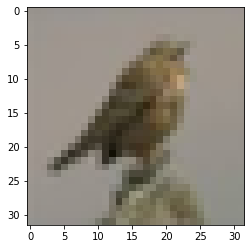

In [11]:
#showtime
plt.imshow(image)

In [14]:
#task2:  check how many labels we have
set(train_data.targets)  #is provided by torch dataset

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [16]:
#task3: for each label, print one sample image
indices = []
numbers = []
for index, number in enumerate(train_data.targets):
    if len(indices) < 10:   #O(1)
        if number not in numbers:
            numbers.append(number)
            indices.append(index)

In [18]:
numbers, indices

([6, 9, 4, 1, 2, 7, 8, 3, 5, 0], [0, 1, 3, 4, 6, 7, 8, 9, 27, 29])

Labels:  [6, 9, 4, 1, 2, 7, 8, 3, 5, 0]


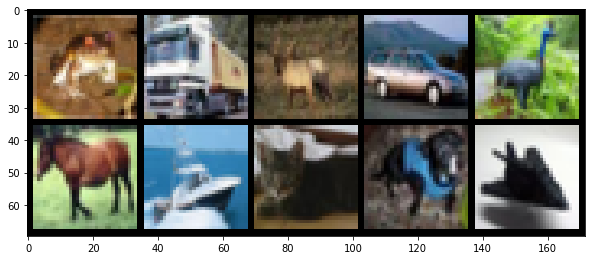

In [37]:
images = []
for i, image_index in enumerate(indices):  #O(1)
    image = train_data[image_index][0]
    images.append(image)

image_tensor = torch.stack(images, 0)
image_tensor.shape #tensor shape:  B, C, W, H  #(10, 3, 32, 32)

print("Labels: ", numbers)

grid_image = make_grid(image_tensor, nrow=5)
grid_image = torch.permute(grid_image, (1, 2, 0))
plt.figure(figsize=(10, 8))
plt.imshow(grid_image)